In [1]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np


import os
os.environ['HTTP_PROXY']="http://www-int.dkfz-heidelberg.de:80"
os.environ['HTTPS_PROXY']="https://www-int.dkfz-heidelberg.de:80"


scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

import warnings

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

In [2]:
base_path="/omics/odcf/analysis/OE0228_projects/VascularAging/rna_sequencing/public_scrnaseq/TabularMuris/senis_droplet_lung.h5ad"
adata = sc.read_h5ad(base_path)
adata=adata[adata.obs.cell_ontology_class == "endothelial cell"]

In [3]:
# filter, normalize total counts and log-transform
sc.pp.filter_genes(adata, min_cells=10)
scv.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

# hvg annotation
sc.pp.highly_variable_genes(adata)
print(f"This detected {np.sum(adata.var['highly_variable'])} highly variable genes. ")

# use scVelo's `moments` function for imputation - note that hack we're using here:
# we're copying our `.X` matrix into the layers because that's where `scv.tl.moments`
# expects to find counts for imputation
adata.layers["spliced"] = adata.X
adata.layers["unspliced"] = adata.X
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

This detected 4228 highly variable genes. 
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:04) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [4]:
!if [ ! -f data/regev_lab_cell_cycle_genes.txt ]; then curl -o data/regev_lab_cell_cycle_genes.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt; fi

In [5]:
sc.pp.scale(adata)
cell_cycle_genes = [x.strip() for x in open('./data/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

s_genes_mm = [gene.lower().capitalize() for gene in s_genes]
g2m_genes_mm = [gene.lower().capitalize() for gene in g2m_genes]
cell_cycle_genes_mm = [gene.lower().capitalize() for gene in cell_cycle_genes]
cell_cycle_genes_mm = [x for x in cell_cycle_genes_mm if x in adata.var_names]
print(len(cell_cycle_genes_mm))
sc.tl.score_genes_cell_cycle(adata,s_genes = s_genes_mm, g2m_genes = g2m_genes_mm)

97
94


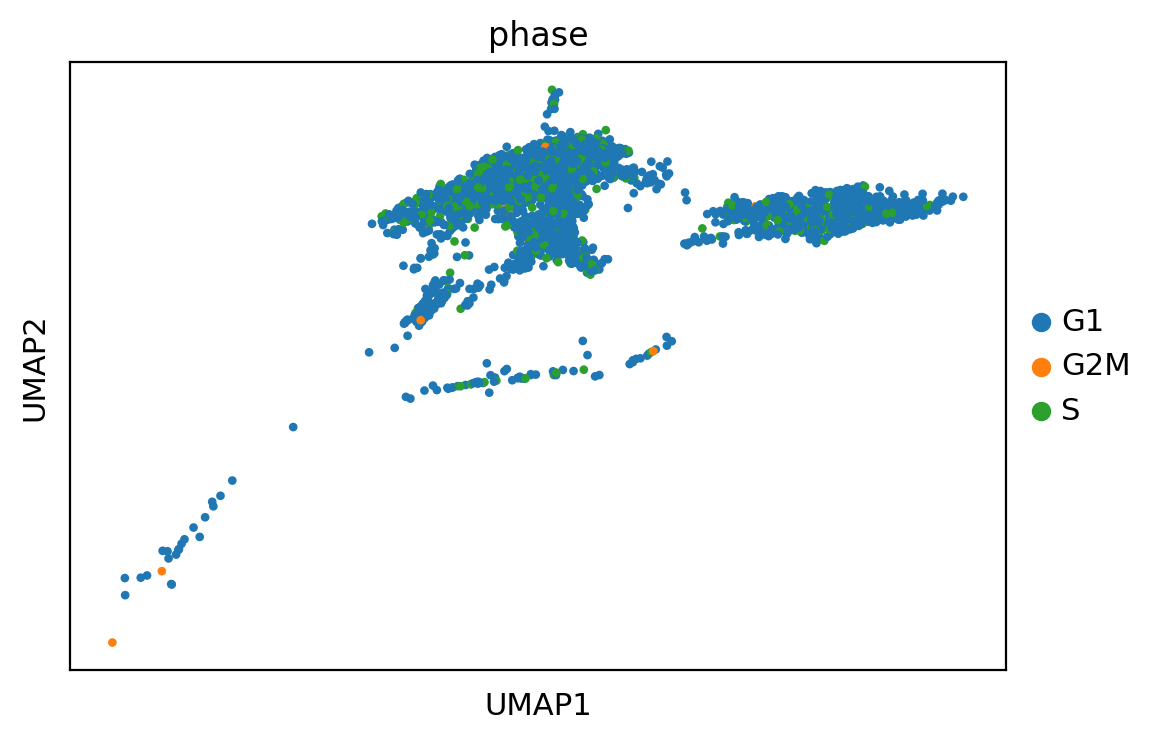

In [6]:


adata_cc_genes = adata[:, cell_cycle_genes_mm]
sc.tl.pca(adata_cc_genes)
sc.pl.umap(adata_cc_genes, color=['phase'])



In [7]:
from cellrank.tl.kernels import CytoTRACEKernel

ctk = CytoTRACEKernel(adata)

sc.tl.draw_graph(adata)

Computing CytoTRACE score with `13018` genes
Adding `adata.obs['ct_score']`
       `adata.obs['ct_pseudotime']`
       `adata.obs['ct_num_exp_genes']`
       `adata.var['ct_gene_corr']`
       `adata.var['ct_correlates']`
       `adata.uns['ct_params']`
    Finish (0:00:03)


In [8]:
adata.obsm

AxisArrays with keys: X_pca, X_umap, X_tsne, X_draw_graph_fa

In [9]:
sc.tl.umap(adata)

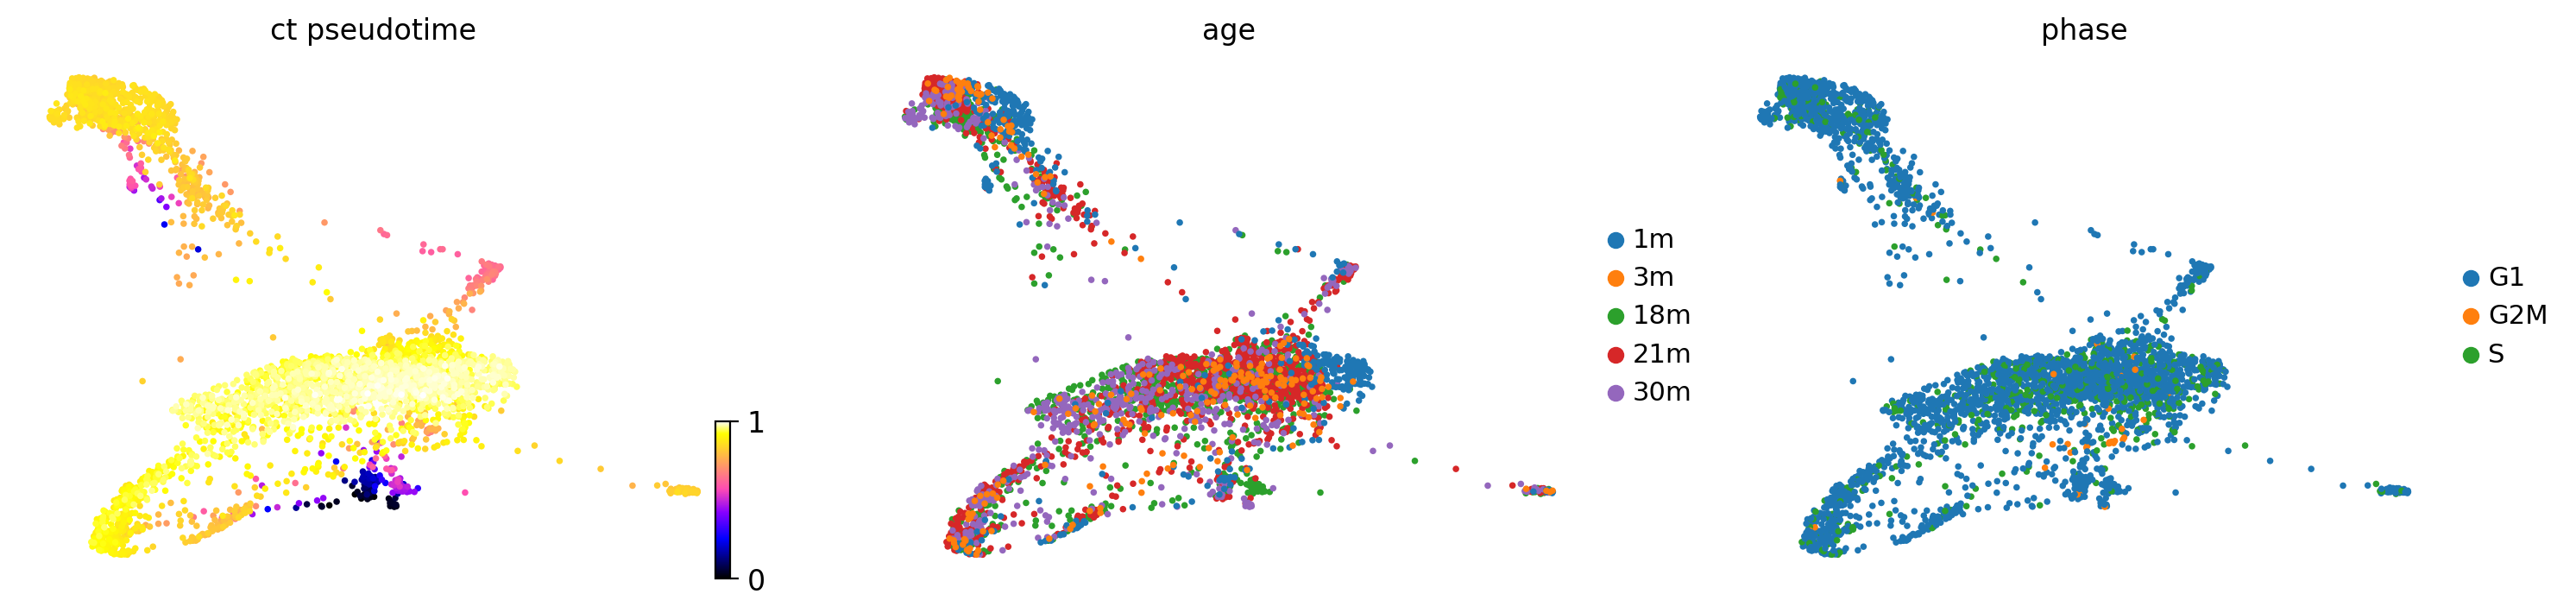

In [10]:
scv.pl.scatter(
    adata,
    c=["ct_pseudotime", "age", "phase"],
    basis=["X_draw_graph_fa"],
    legend_loc="right",
    color_map="gnuplot2",
)

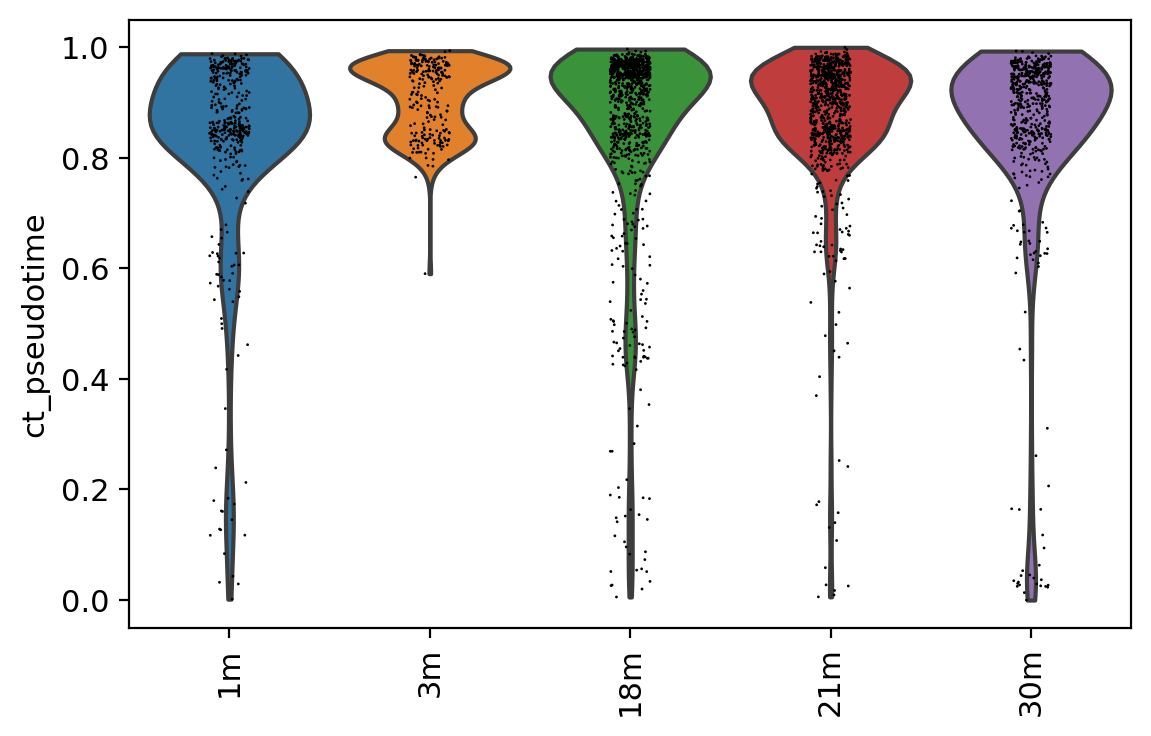

In [11]:
sc.pl.violin(adata, keys=["ct_pseudotime"], groupby="age", rotation=90)

In [12]:
ctk.compute_transition_matrix(threshold_scheme="soft", nu=0.5)

Computing transition matrix based on `ct_pseudotime`


100%|██████████| 3069/3069 [00:01<00:00, 1678.88cell/s]


    Finish (0:00:06)


<CytoTRACEKernel>

Projecting transition matrix onto `draw_graph_fa`
Adding `adata.obsm['T_fwd_draw_graph_fa']`
    Finish (0:00:03)


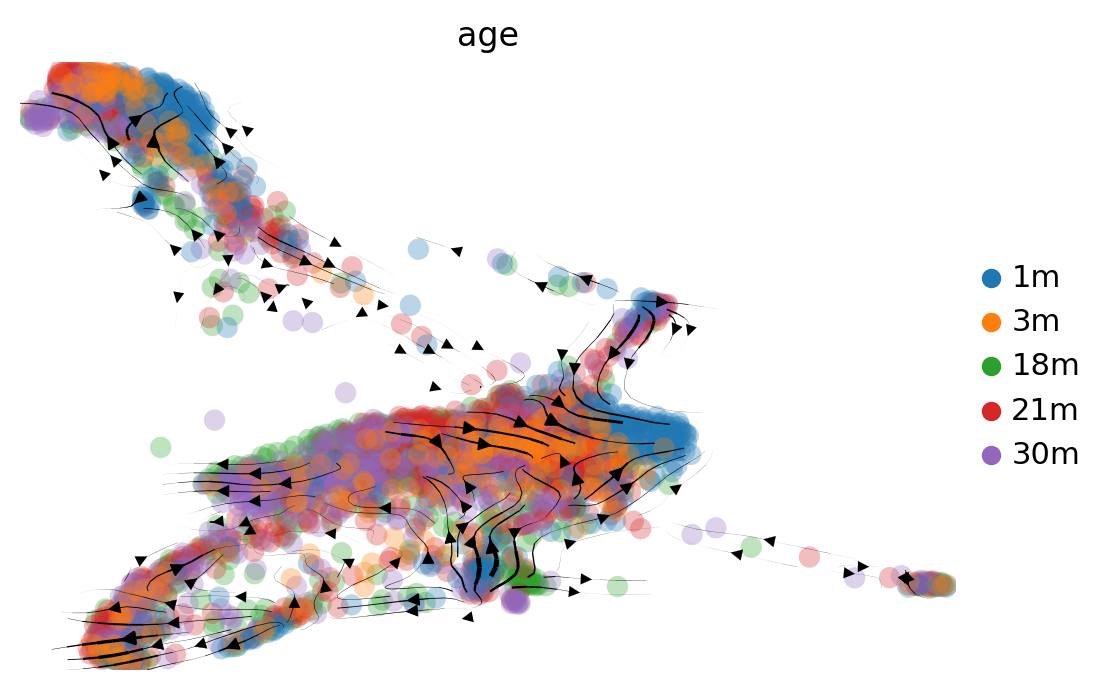

In [13]:
ctk.compute_projection(basis="draw_graph_fa")
scv.pl.velocity_embedding_stream(
    adata, color="age", vkey="T_fwd", basis="draw_graph_fa", legend_loc="right"
)

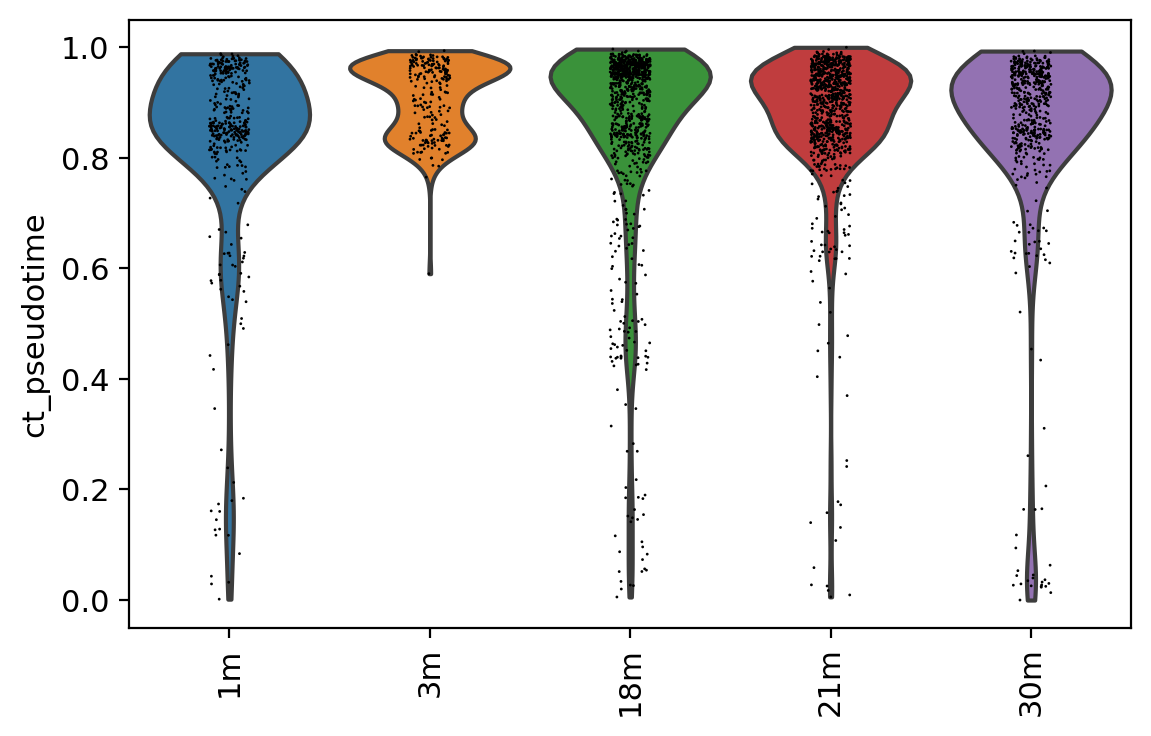

In [14]:
sc.pl.violin(adata, keys=["ct_pseudotime"], groupby="age", rotation=90)

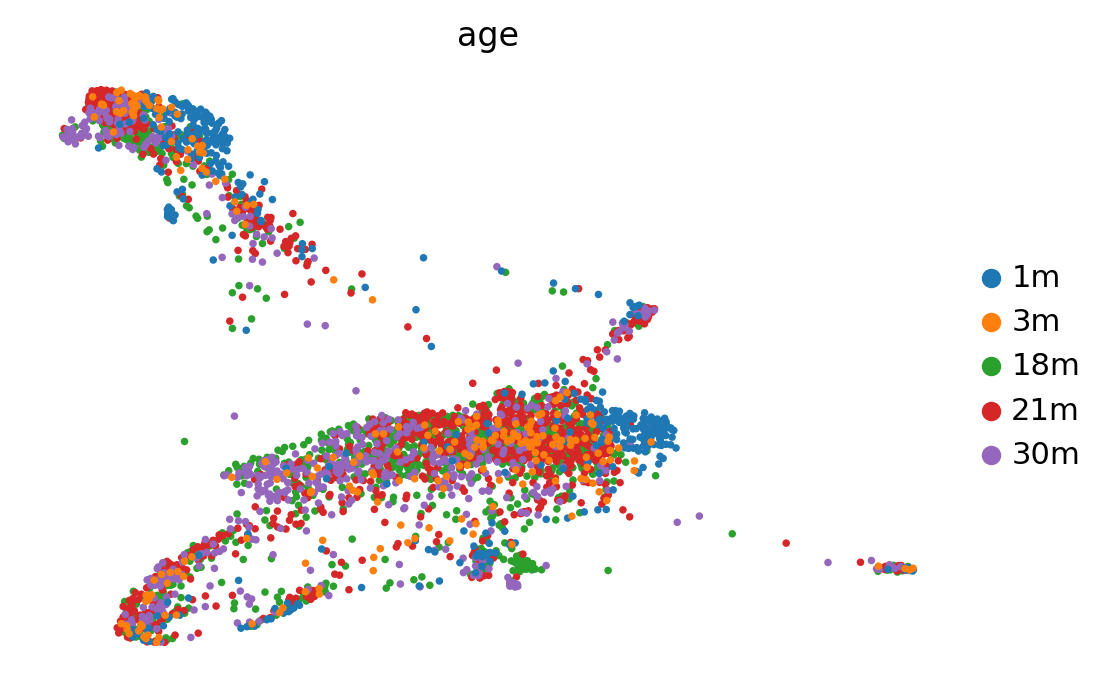

Simulating `15` random walks of maximum length `768`


100%|██████████| 15/15 [00:03<00:00,  4.91sim/s]


    Finish (0:00:03)
Plotting random walks


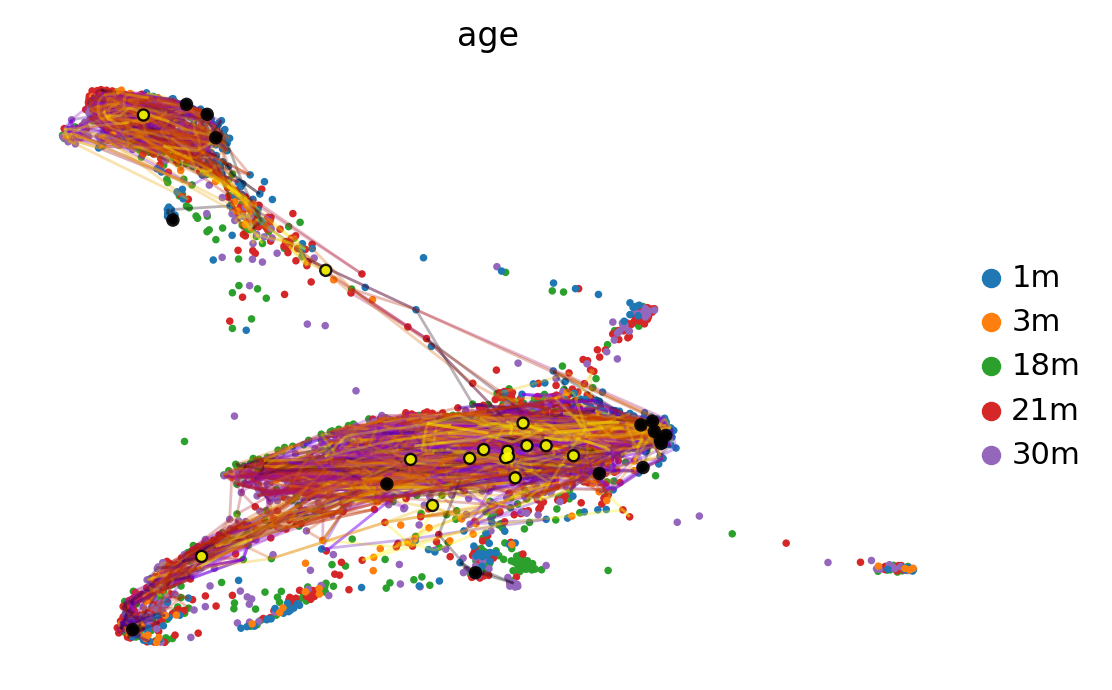

In [15]:
scv.pl.scatter(
    adata, basis="draw_graph_fa", c="age", legend_loc="right"
)
ctk.plot_random_walks(
    n_sims=15,
    start_ixs={"age": "1m"},
    basis="draw_graph_fa",
    color="age",
    legend_loc="right",
    seed=1,
)

GPCCA[n=3069, kernel=<CytoTRACEKernel[dnorm=False, scheme=soft, b=10.0, nu=0.5]>]
Computing Schur decomposition
Mat Object: 1 MPI processes
  type: seqdense
1.0000000000000091e+00 -7.1814537577939361e-04 1.8645412899043880e-03 -6.3176504429968226e-03 -2.1398861499986846e-03 -6.8692113211777364e-03 2.1917351897330861e-02 -1.3840467586825464e-02 1.9066488337191413e-02 2.2326579781000505e-03 9.0419687548672096e-03 2.1346974589262439e-02 4.2922375221262059e-03 -1.2677111684207239e-02 -1.0826266971892559e-02 6.9710992146119755e-03 9.0652834047282183e-03 -1.1085820498870386e-02 -3.1400786454101222e-02 -5.4608225605839826e-03 
0.0000000000000000e+00 9.9856924021456872e-01 -7.6790574874394373e-04 3.0507687414933148e-03 7.2008608191105573e-04 4.9093542819422312e-03 -3.9271520582977379e-03 -1.7060764461402887e-02 -9.4712216039323331e-03 1.6528520428910028e-03 1.1035539848686955e-02 -9.6487153819168701e-03 1.8786246623189762e-05 -1.5890383391850046e-02 1.0600811836430307e-02 4.7321722971021586e-0

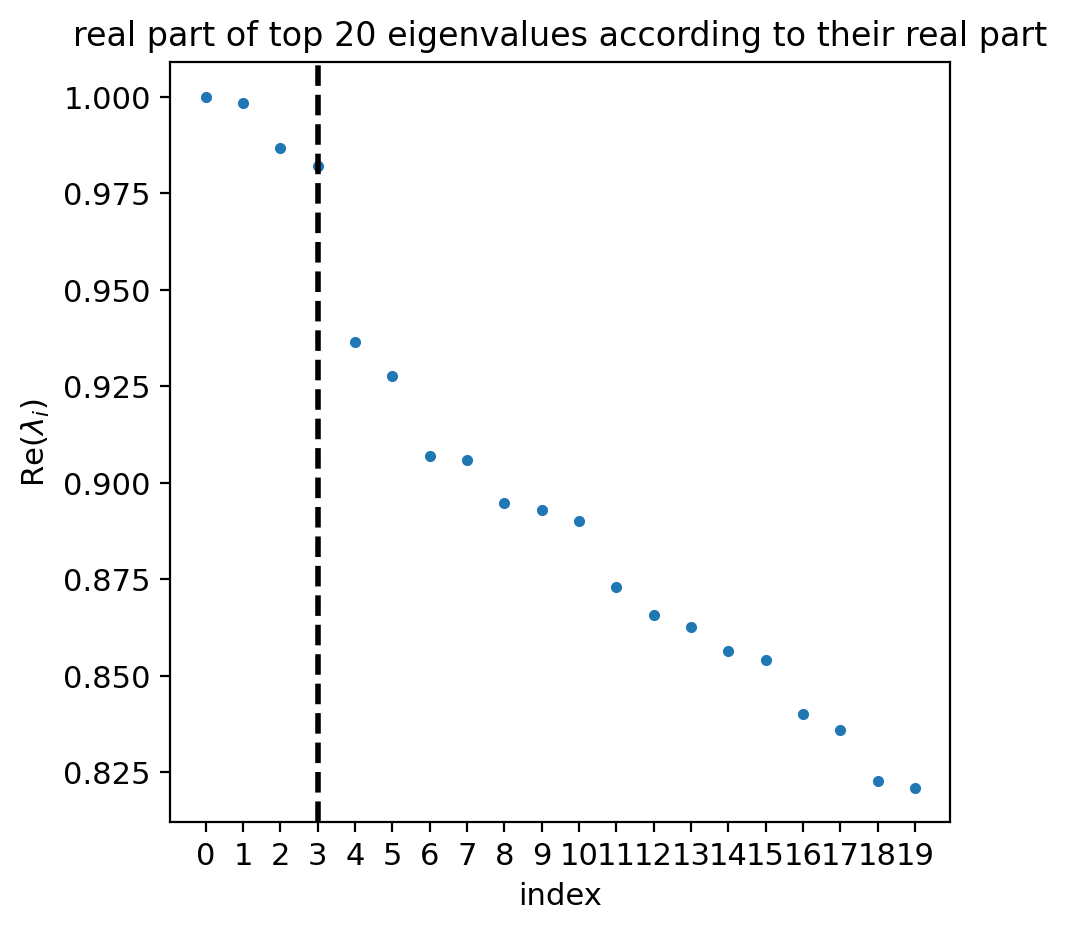

In [16]:
from cellrank.tl.estimators import GPCCA

g_fwd = GPCCA(ctk)
print(g_fwd)

g_fwd.compute_schur(n_components=20)
g_fwd.plot_spectrum(real_only=True)

Computing `3` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


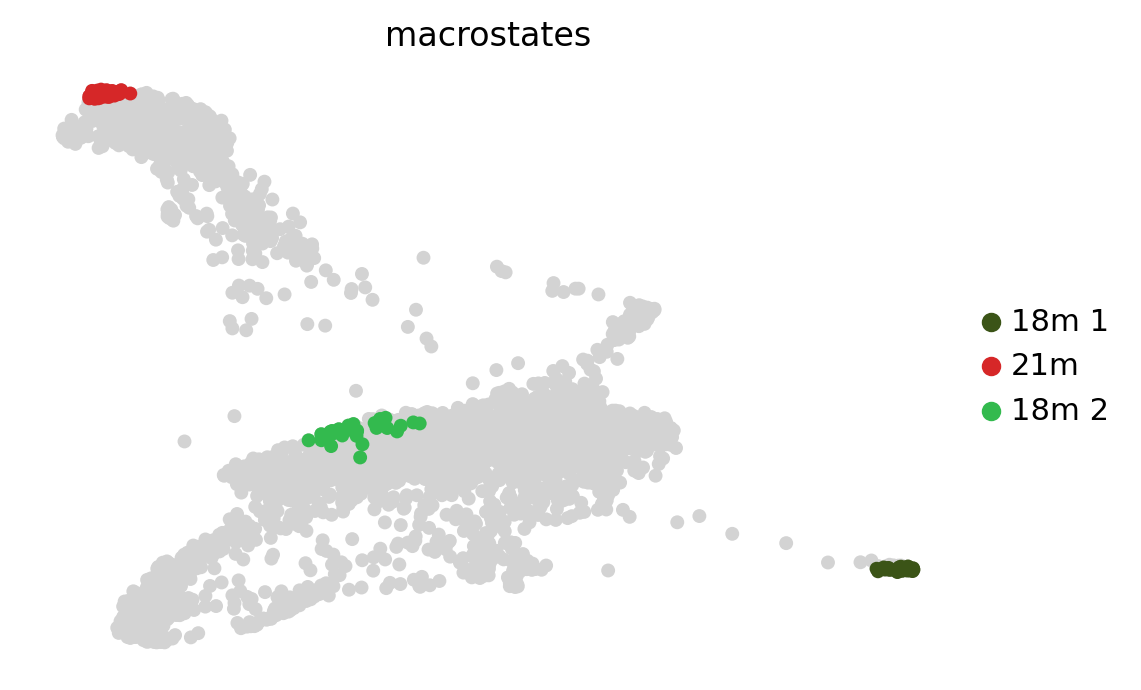

In [17]:
g_fwd.compute_macrostates(n_states=3, cluster_key="age")
g_fwd.plot_macrostates(
    discrete=True, legend_loc="right", size=100, basis="draw_graph_fa"
)


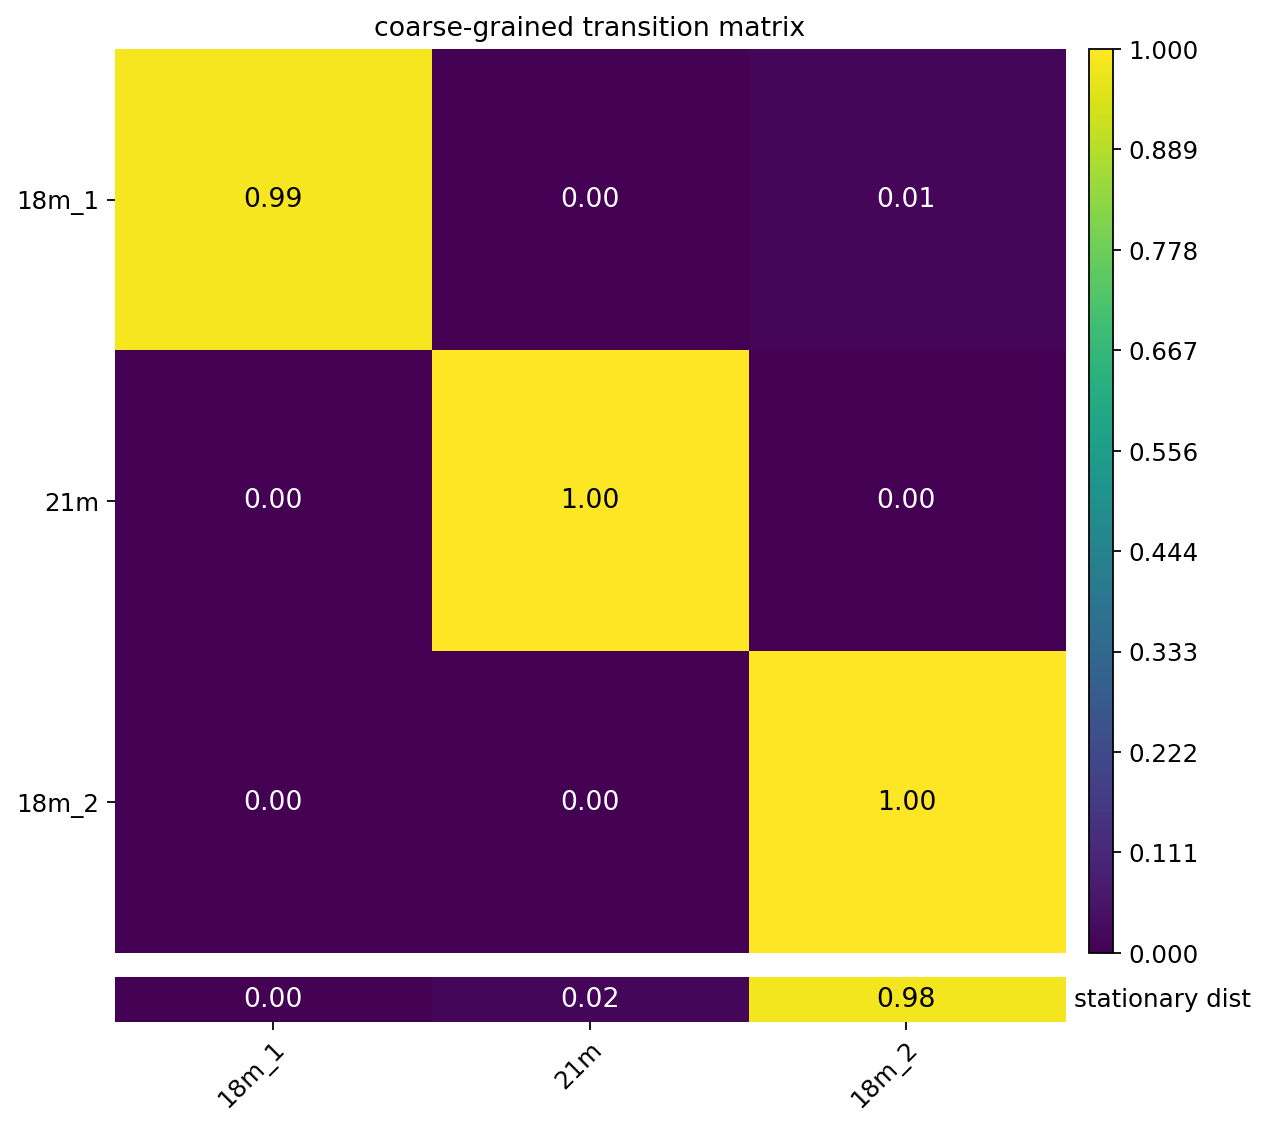

In [18]:
g_fwd.plot_coarse_T()

In [19]:
g_fwd.compute_terminal_states()
g_fwd.compute_absorption_probabilities()


Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`
Computing absorption probabilities


100%|██████████| 3/3 [00:00<00:00, 45.26/s]

Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:00)



[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger


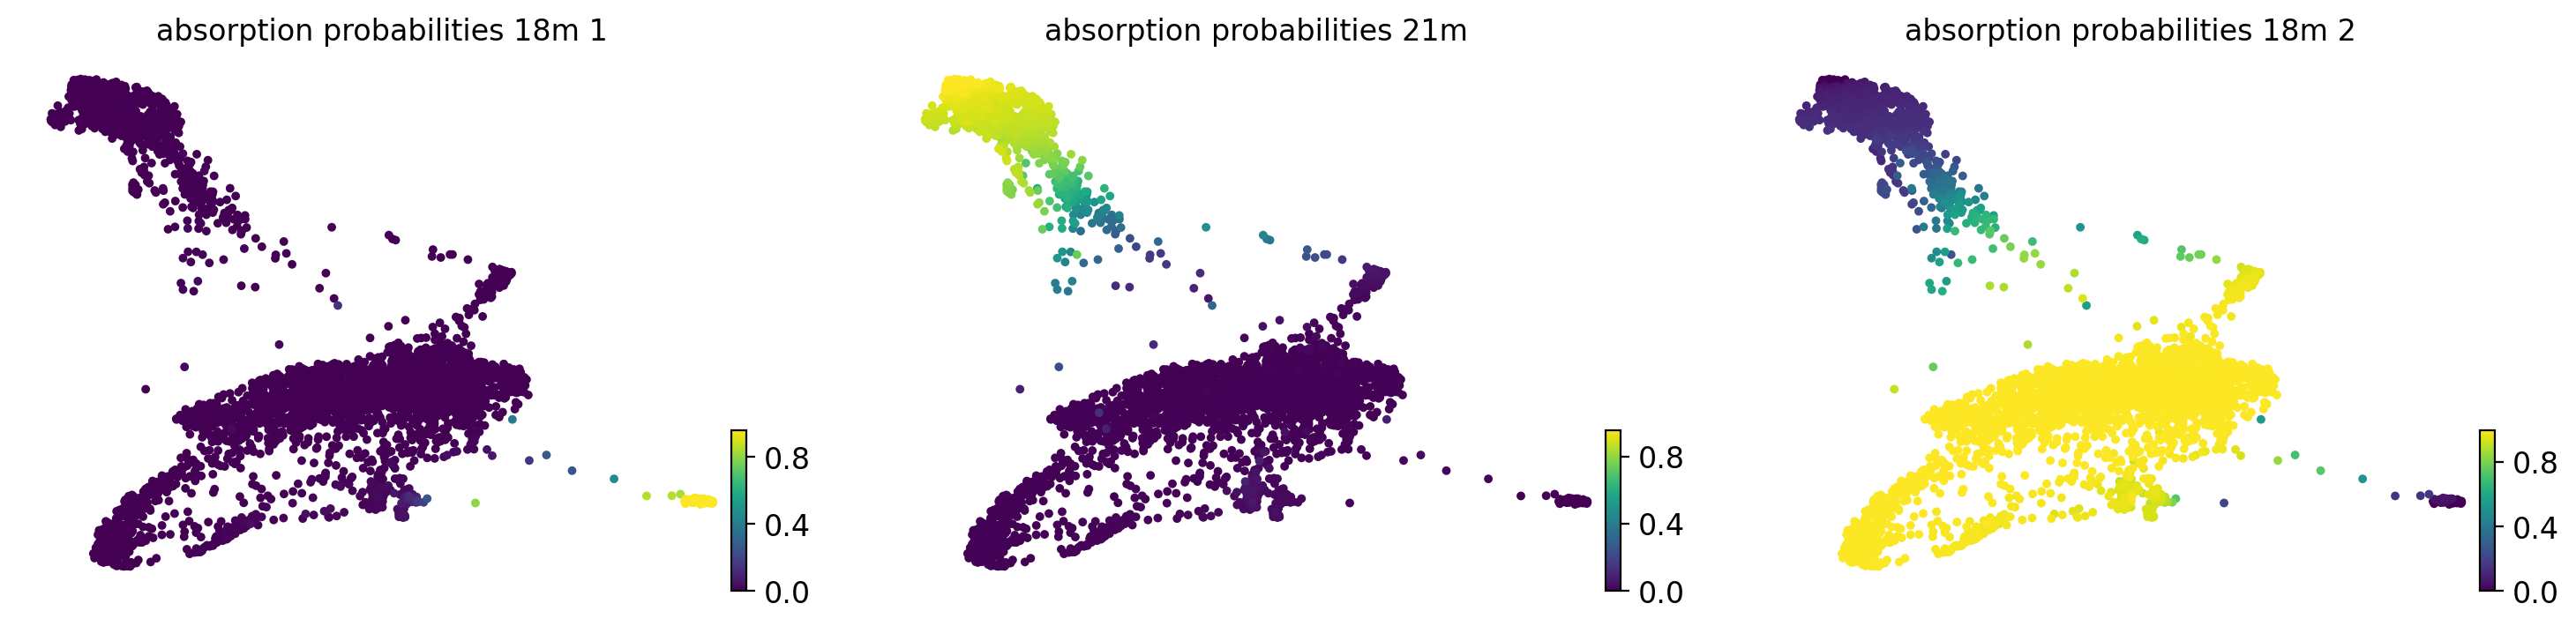

In [20]:
g_fwd.plot_absorption_probabilities(same_plot=False, size=50, basis="draw_graph_fa")


In [21]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, random_state=0)

In [22]:
from cellrank.external.kernels import WOTKernel
adata.obs["num_age"] =adata.obs.age.str[:-1]

In [23]:
wk = WOTKernel(adata, time_key="num_age")

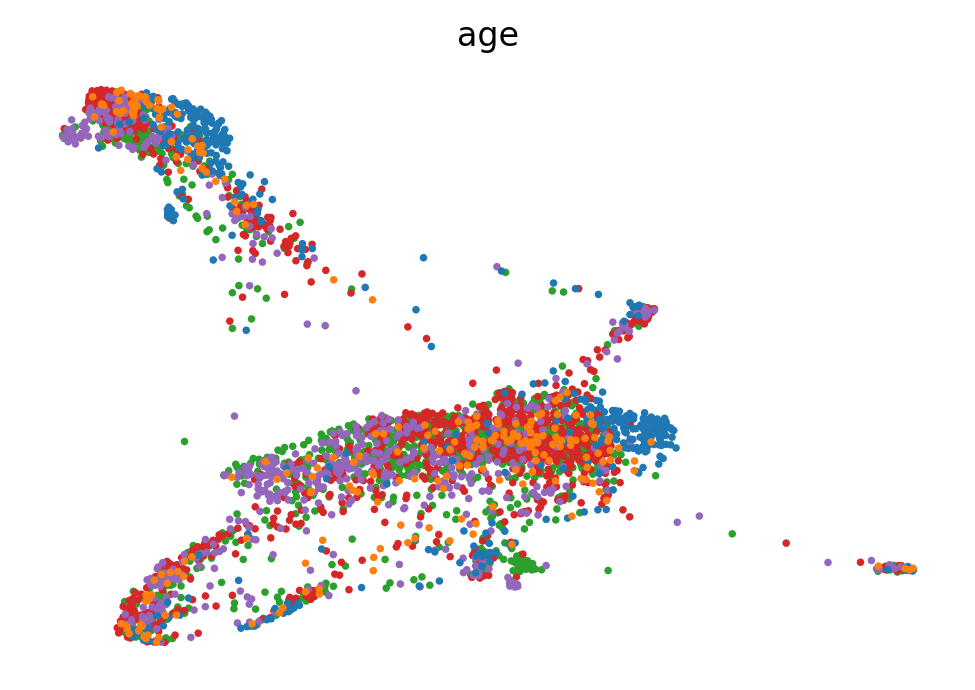

In [24]:
scv.pl.scatter(adata, basis="draw_graph_fa", c="age", legend_loc="none")


Computing `proliferation` scores
Computing `apoptosis` scores


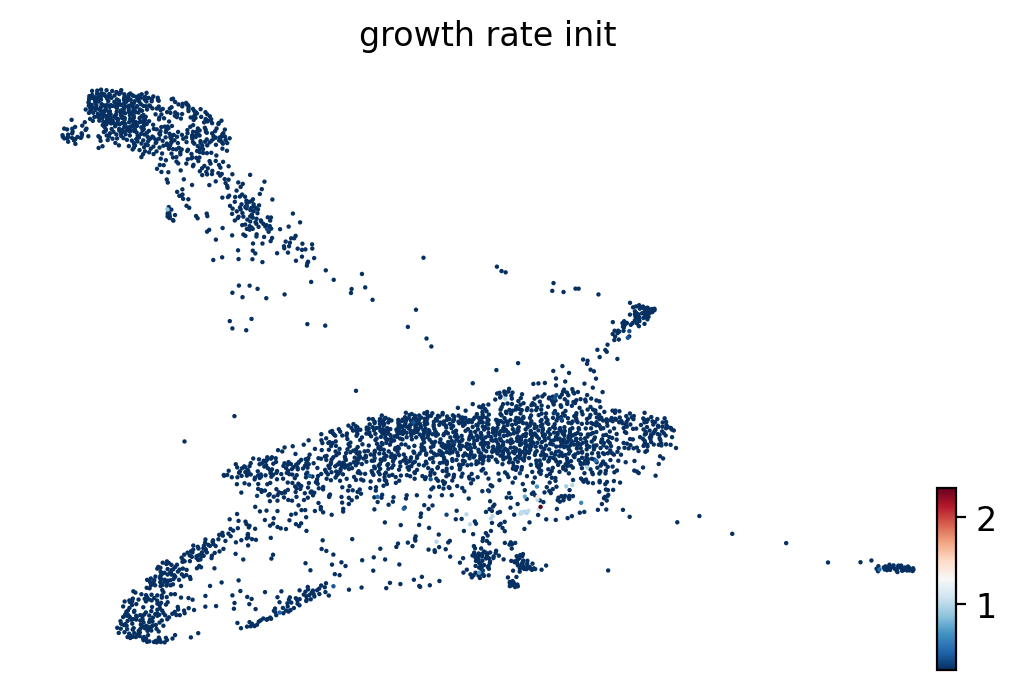

In [25]:
wk.compute_initial_growth_rates(organism="mouse", key_added="growth_rate_init")
scv.pl.scatter(
    adata, c="growth_rate_init", legend_loc="right", basis="draw_graph_fa", s=10
)


In [26]:
wk.compute_transition_matrix(
    growth_iters=3, growth_rate_key="growth_rate_init", last_time_point="connectivities"
)

Computing transition matrix using Waddington optimal transport
Using `4228` HVGs from `adata.var['highly_variable']`
Using default cost matrices
Computing transport maps for `4` time pairs


100%|██████████| 4/4 [01:09<00:00, 17.30s/time pair]

    Finish (0:01:09)


Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
Using `threshold=0.0010901221537321971`
    Finish (0:01:12)


<WOTKernel>

Simulating `50` random walks of maximum length `200`


100%|██████████| 50/50 [00:05<00:00,  9.17sim/s]

    Finish (0:00:05)



[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple MacOS to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Plotting random walks


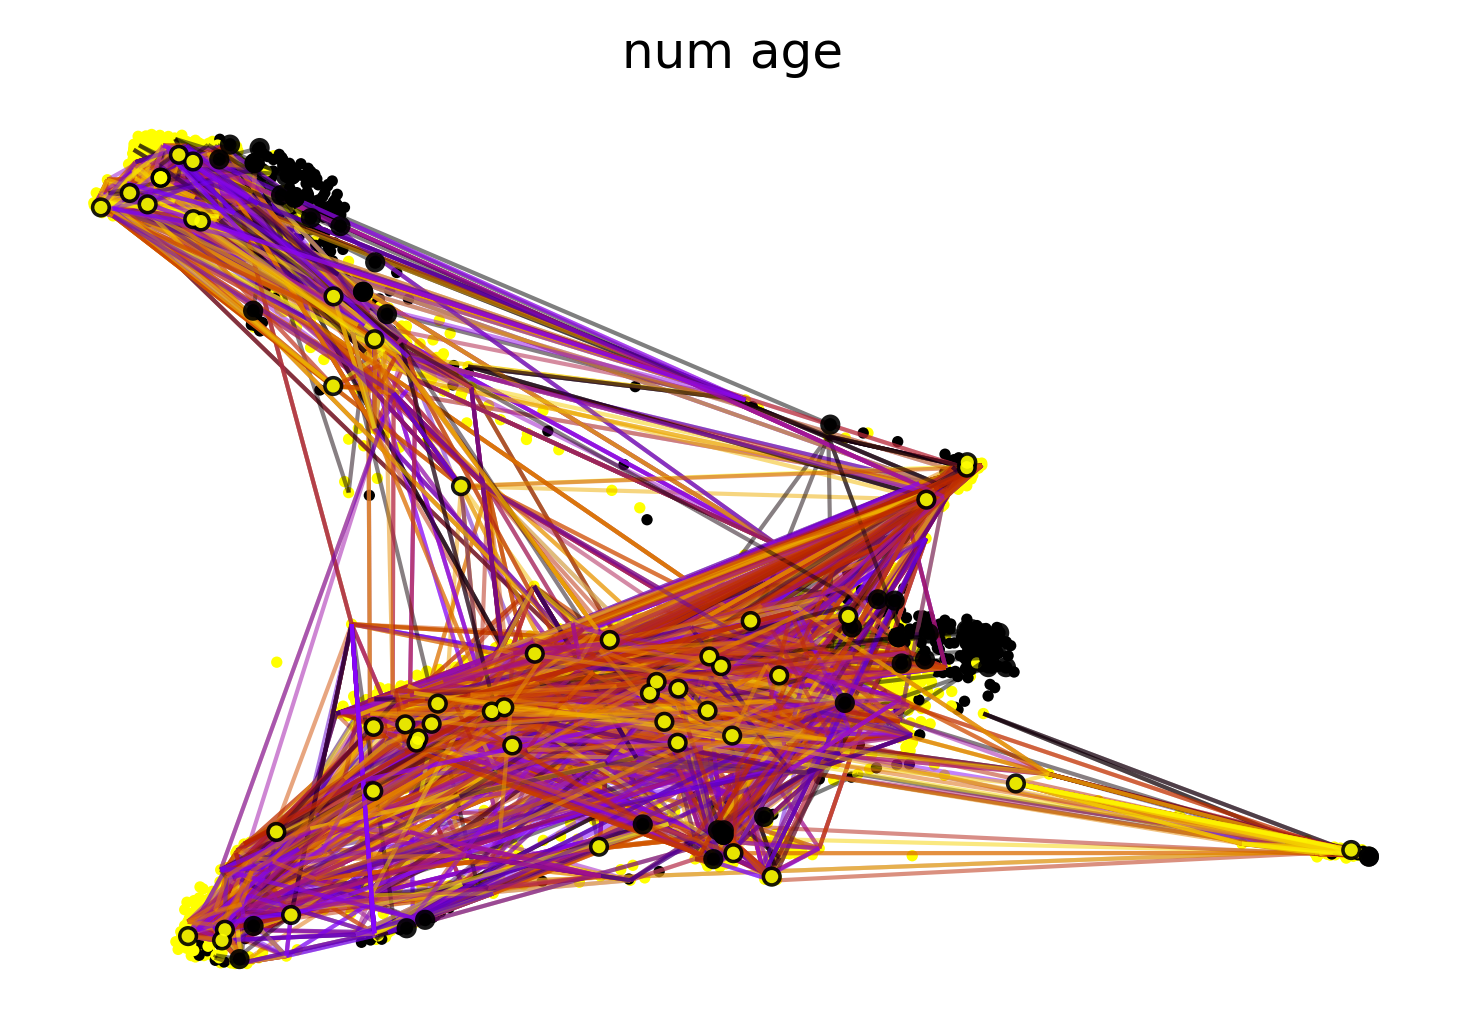

In [27]:
wk.plot_random_walks(
    n_sims=50,
    max_iter=200,
    start_ixs={"num_age": 1},
    basis="draw_graph_fa",
    c="num_age",
    legend_loc="none",
    linealpha=0.5,
    dpi=150,
)


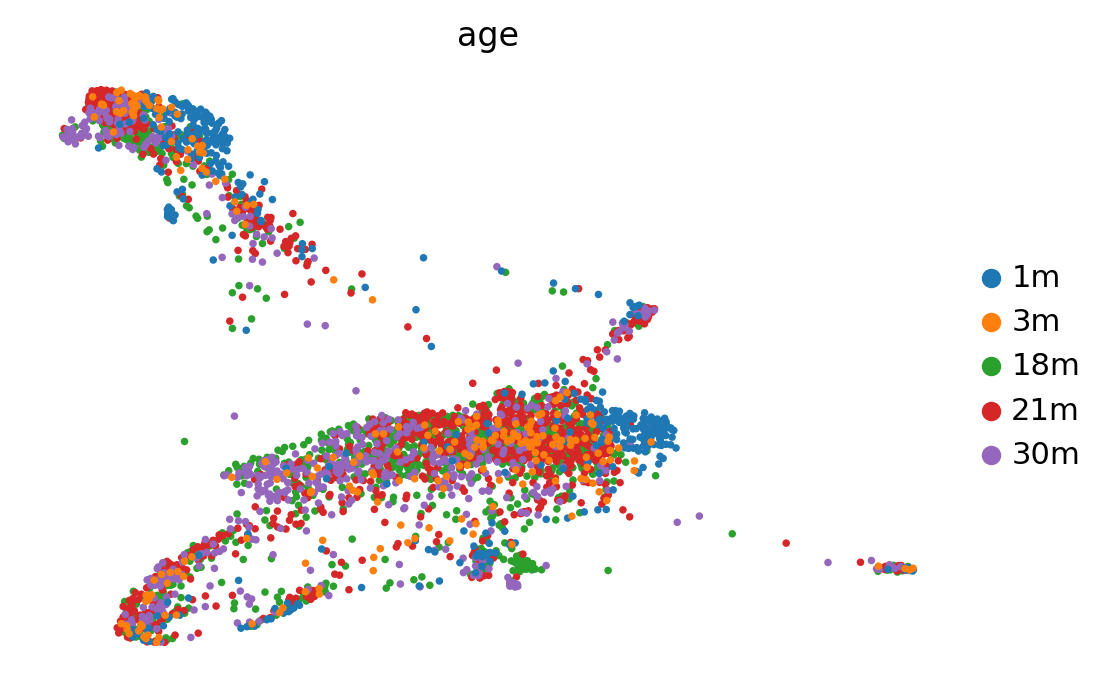

In [28]:
scv.pl.scatter(adata, c="age", basis="draw_graph_fa", legend_loc="right")

In [29]:
ax = wk.plot_single_flow(
    cluster_key="age",
    time_key="num_age",
    cluster="30m",
    min_flow=0.1,
    xticks_step_size=4,
    show=False,
    dpi=100,
    clusters=["30m", "21m"],
)

# prettify the plot a bit, rotate x-axis tick labels
locs, labels = plt.xticks()
ax.set_xticks(locs)
ax.set_xticklabels(labels, rotation=90)

plt.show()

Computing flow from `30m` into `1` cluster(s) in `1` time points


ValueError: After removing clusters with no incoming flow edges, none remain.

In [ ]:
adata.obs

In [ ]:
from cellrank.tl.kernels import ConnectivityKernel
ck = ConnectivityKernel(adata)
ck.compute_transition_matrix()

combined_kernel = 0.9 * wk + 0.1 * ck

In [ ]:
g = GPCCA(combined_kernel)

In [ ]:
g.compute_schur()
g.plot_spectrum(real_only=True)

In [ ]:
g.compute_macrostates(n_states=1, cluster_key="age")
g.plot_macrostates(discrete=True, basis="draw_graph_fa", legend_loc="right")

In [ ]:
g.plot_macrostate_composition(key="age")

In [ ]:
g.compute_terminal_states()
g.compute_absorption_probabilities(solver="gmres", use_petsc=True)

In [ ]:
g.plot_absorption_probabilities(same_plot=False, basis="draw_graph_fa", perc=[0, 99])

In [ ]:
cr.pl.log_odds(
    adata,
    lineage_1="30m",
    lineage_2=None,
    time_key="num_age",
    keys=["Terf1"],
    threshold=0,
    size=2,
    xticks_step_size=4,
    figsize=(9, 4),
)

In [ ]:
g.compute_lineage_drivers(return_drivers=False)

In [ ]:
adata.var["means"] = adata.X.A.mean(axis=0)